In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import itertools
import sys
import os
import math
sys.path.append('../..')
import scipy.optimize as opt
from joblib import Parallel, delayed
from functools import partial
from hyperopt import hp, tpe, fmin, Trials
from models.optim.gaboh_choice_opt import SEIR

In [64]:
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def calculate_opt(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
    return(grad1, states_int_array/N)

In [65]:
grad1, states_base = calculate_opt(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=500)
print(grad1)

46.3893082


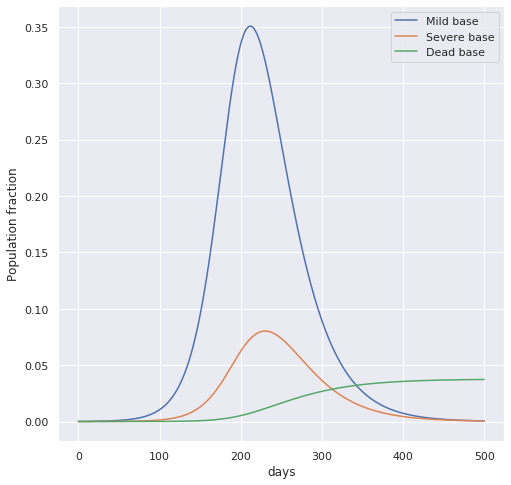

In [69]:
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

In [76]:
def check(start_array, duration_array, choice_array, total_resource):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)
    
def calculate_opt_val(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
    return(grad1)
    
def grid_search(num_int, total_resource=60, day0=10):
    min_val = 500
    min_params = {}
    params = []
    min_duration = 10
    max_duration = total_resource*np.array([4,2,1])
   
    if(num_int == 1):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val))
        choice_tuple = list(itertools.product(choice_val))
        duration_tuple = list(itertools.product(duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
        
    if(num_int == 2):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
            
    if(num_int == 3):
        start_val = [start for start in range(day0, day0+365, 50)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 20)]
        start_tuple = list(itertools.product(start_val, start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
        
                            
    print(len(params))

    value_array = Parallel(n_jobs=40)(delayed(calculate_opt_val)(intervention_day=par[0], intervention_duration=par[2],\
                                                             intervention_choice=par[1], days = 400) for par in params)
    value_array = np.array(value_array)
    min_val = np.min(value_array)
    i = np.argmin(value_array)
    min_params['start_array'] = params[i][0]
    min_params['duration_array'] = params[i][2]
    min_params['choice_array'] = params[i][1]
    
    return(min_val, min_params)  

74
33.4919116


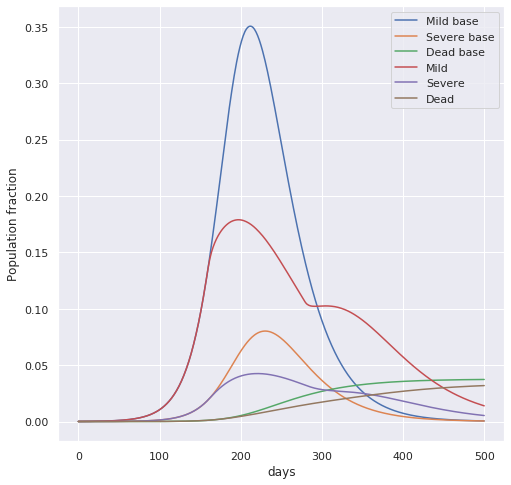

In [74]:
#num_int = 1
min_val, min_params = grid_search(num_int=1)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

67015
31.764172399999996


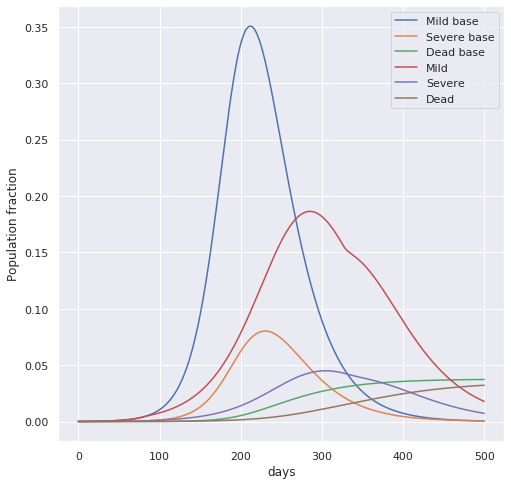

In [75]:
#num_int = 2
min_val, min_params = grid_search(num_int=2)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

5244
32.326955299999995


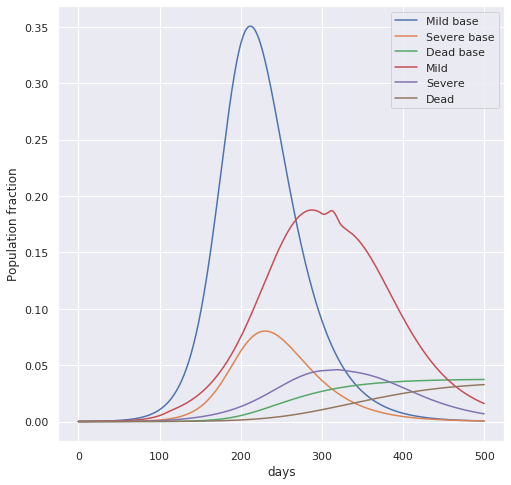

In [77]:
#num_int = 3
min_val, min_params = grid_search(num_int=3)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

In [81]:
def check(start_array, duration_array, choice_array, total_resource):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)

    
def mod_calculate_opt(variable_params, total_resource, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource)):
        return(100)
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
        
    return(grad1)


def tpe_opt(num_int, total_resource=60, day0=10):
    if(num_int==1):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val),hp.choice('id_1', start_val)],
            'intervention_duration' : [hp.choice('du_0', duration_val),hp.choice('du_1', duration_val)],
            'intervention_choice' : [hp.choice('ic_0', choice_val),hp.choice('ic_1', choice_val)],
        }

    partial_calculate_opt = partial(mod_calculate_opt, total_resource=total_resource, days=400) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)
    

In [82]:
tpe_opt(num_int=1)

100%|██████████| 3000/3000 [01:12<00:00, 41.35trial/s, best loss: 32.017360499999995]


In [83]:
tpe_opt(num_int=2)

100%|██████████| 3000/3000 [01:41<00:00, 29.56trial/s, best loss: 36.7511194]


## Heuristic Based Method

In [84]:
from models.optim.grad_opt import SEIR
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def run_seir(days, int_vec):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    derivatives = np.ones((days,9))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    coeficeint= np.array([S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                          R_R_fatal_coeficeint,C_coeficeint,D_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,(derivatives[i]/N))
        grad1[i] = np.dot(coeficeint,(states_int_array[:,i]/N))
    return(grad1, states_int_array/N)

In [85]:
total_resource = 120
resource_spent = 0
window = 5
int_vec = np.ones(500)
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(int_vec[day_max]>=3):
        day_max = arg_curve[i]
        i += 1

    int_vec[day_max] += 0.25 
    resource_spent += 0.25

In [86]:
int_vec

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [87]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))
curve_base, states_base = run_seir(days = 500, int_vec=np.ones(500))
np.sum(curve_base)

41.8273911


46.35119159999999

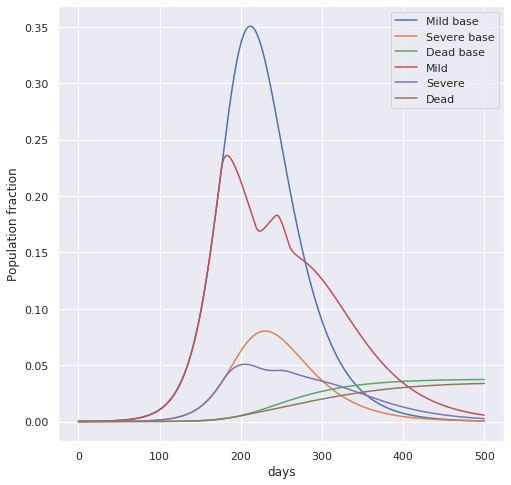

In [88]:
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

## Smart Heuristic Method

In [89]:
def get_overlap(ps,pe,s,e):
    if(s>pe or e<ps):
        return(0)
    else:
        max_s = max(ps,s)
        min_e = min(pe,e)
        return(min_e - max_s + 1)
    
def get_dist(tup1, tup2):
    return(abs(sum(tup1)-sum(tup2)))

def shift(ps,pe,s,e):
    if(ps+pe > s+e):
        return(e+1,pe+e-ps+1)
    else:
        return(ps+s-pe-1,s-1)

def check_overlap(p_time, int_list):
    if(not len(int_list)):
        return(p_time)
    elif(len(int_list)<5 and len(int_list)>=1):
        (ps, pe) = p_time
        max_overlap = 0
        mo_s, mo_e = 0, 0
        for i in range(len(int_list)):
            s, e = int_list[i]
            overlap = get_overlap(ps,pe,s,e)
            if(overlap>5):
                return((s,e))
            if(overlap>max_overlap):
                max_overlap = overlap
                mo_s, mo_e = s, e
                
        if(max_overlap==0):
            return((ps,pe))
        else:
            ns, ne = shift(ps,pe,mo_s,mo_e)
            if(ns<30):
                return((mo_s,mo_e))
            for i in range(len(int_list)):
                s, e = int_list[i]
                overlap = get_overlap(ns,ne,s,e)
                if(overlap>0):
                    return((mo_s,mo_e))
            return((ns,ne))
        
    else:
        min_dist = 500
        min_dist_s = 0
        min_dist_e = 0
        for i in range(len(int_list)):
            dist = get_dist(p_time, int_list[i])
            if(dist<min_dist):
                min_dist_s, min_dist_e = int_list[i]
        return((min_dist_s,min_dist_e))

In [90]:
total_resource = 120
resource_spent = 0
min_d = 10
init_day = 10
max_num_int = 5
int_vec = np.ones(500)
interventions = []
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(day_max<init_day or int_vec[day_max]>=2):
        day_max = arg_curve[i]
        i += 1

    buffer = day_max - init_day
    if(buffer<min_d/2):
        (start,end) = check_overlap((init_day, init_day+min_d),interventions)
    else:
        (start,end) = check_overlap((day_max-min_d/2+1, day_max+min_d/2),interventions)
        
    start, end = int(start), int(end)
    
    if(int_vec[start]==1):
        int_vec[start:end+1] = 1.5
        resource_spent += 2.5
    elif(int_vec[start]==1.5):
        int_vec[start:end+1] = 2
        resource_spent += 2.5
    else:
        int_vec[start:end+1] = 3
        resource_spent += 5 
    if((start,end) not in interventions):
        interventions.append((start,end))

In [91]:
int_vec

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.

In [92]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))
curve_base, states_base = run_seir(days = 500, int_vec=np.ones(500))
np.sum(curve_base)

44.5240539


46.35119159999999

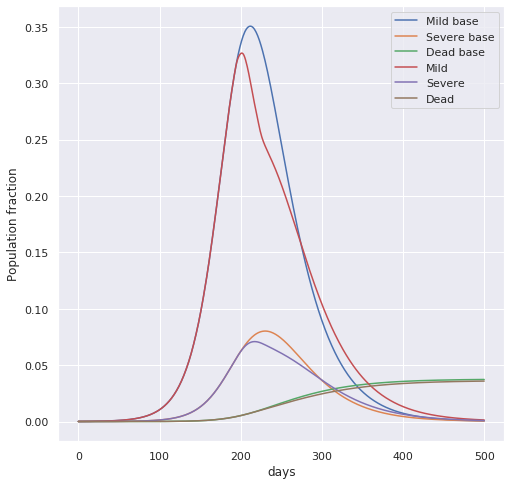

In [93]:
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

## Gradient Based Methods

In [94]:
import sys
sys.path.append('../..')
from models.optim.grad_opt import SEIR
def run_seir_grad(days, int_vec):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    derivatives = np.ones((days,9))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    coeficeint= np.array([S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                          R_R_fatal_coeficeint,C_coeficeint,D_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,(derivatives[i]/N))
        grad1[i] = np.dot(coeficeint,(states_int_array[:,i]/N))
    return(grad1)

In [95]:
def get_grad(int_vec):
    days = len(int_vec)
    num_pts = 3  # number of points used for derievative.
    grad_vec = np.ones(days)
    for i in range(10, days):
    #     i represents the ith dimension of T_transi
        val = int_vec[i]
        window_size = 0.005
        values = np.random.uniform(val-window_size, val+window_size, num_pts)
        f_values = np.ones_like(values)
        for j,value in enumerate(values):
            int_vec[i] = value
            f_values[j] = np.sum(run_seir_grad(days, int_vec))
        values = np.append(values,val)
        int_vec[i] = val
        fval = np.sum(run_seir_grad(days, int_vec))
        f_values = np.append(f_values,fval)
        derivative = np.gradient(f_values, values, edge_order=2)
        grad_vec[i] = derivative[-1]
    return(grad_vec)

In [96]:
from pulp import *
def opt_step(grad):
    prob = LpProblem("Minimization over constrained space",LpMinimize)

    day_list = list((np.arange(500-10)).astype(str))

    int_days = LpVariable.dicts("day",day_list,lowBound=1,upBound=3,cat='Continuous')

#     grad = get_grad(np.ones(400))

    prob += lpSum([grad[int(i)]*int_days[i] for i in day_list]) #objective function
    prob += lpSum([int_days[f] for f in day_list]) <= 620.0-10.0 #TotalResource
    prob.solve()
    opt_val = np.ones(500)
    for v in prob.variables():
        idx = v.name.split('_')[-1]
        opt_val[int(idx)+10] = v.varValue
        
    return(opt_val)

In [ ]:
num_iter = 100
best_val = 50
int_vec = np.ones(500)
best_int_vec = np.ones(500)
for i in range(num_iter):
    gradient = get_grad(int_vec)
    opt = opt_step(gradient)
    gamma = 2.0/(3+i)
    int_vec = int_vec + gamma*(opt-int_vec)
    value = np.sum(run_seir_grad(int_vec=int_vec,days=500))
    print(value)
    if(value < best_val):
        best_val = value
        best_int_vec = int_vec
print(best_val)

/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


44.2900783
42.91209
42.5861356
42.264020099999996
42.0800504
42.1126663
41.9238335
41.8532802
41.878941600000005
41.6955803
41.77490149999999
41.891408299999995
41.461906600000006
41.5968357
41.544663
41.562685099999996
41.30726959999999
41.213093699999995
41.1337046
41.2880115
41.2842639
41.1222236
41.2229535
41.1147899
41.2695737
41.0868674
40.9840625
41.08965839999999
41.09250510000001
40.9867165
41.1007125
41.098157
40.9544534
40.981553399999996
41.0477876
40.891105399999994
41.0171367
41.0186722
41.0346577
40.95394519999999
40.9209109
40.947597699999996
40.951873000000006
40.86057649999999
40.8903917
40.978544799999995
41.053201
40.869049800000006
40.9547091
40.8257653
40.9594484
40.9754983
40.890659500000005
41.0693506
40.88672329999999
40.866762
41.088497800000006
40.966699999999996
40.9540699
40.88291949999999
40.9982267
40.905642799999995
41.0247575
40.9324873
40.94759119999999
40.9291716
40.8879184
40.9283444
40.8884683
40.9588244
40.9014305
40.8837223
40.9317029
40.8549727
4

40.6931536


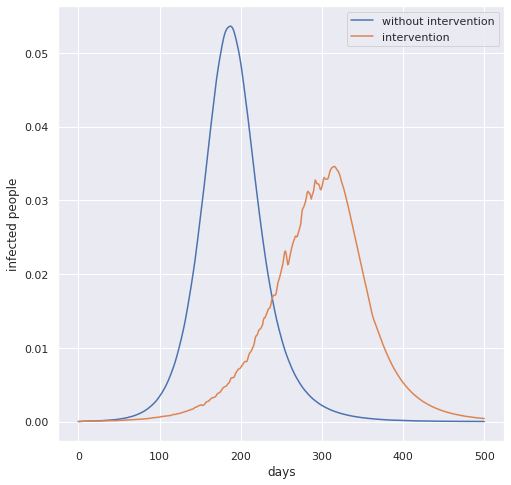

In [99]:
print(best_val)
curve, states = run_seir(days=500, int_vec=best_int_vec)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()